In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import numpy as np
from pandas import Series
import seaborn as sns
from matplotlib.pyplot import figure
import cmocean.cm as cmo
import seaborn as sns

from pylab import rcParams
from numpy import diff
from scipy import interpolate
import scipy.stats as stats

from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

import matplotlib.gridspec as gridspec

import cmocean
import cmocean.cm as cmo
import seaborn as sns

from scipy.interpolate import interp1d

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
df_doc = pd.read_csv('../Dissertation_projects/Data/TOC/TOC_GOM.csv', sep=',', index_col=0)

#make all BDL a 0 
df_doc.loc[df_doc['NPOC_uM'] == 'BLD', 'NPOC_uM'] = 0
df_doc.loc[df_doc['TN_uM'] == 'BLD', 'TN_uM'] = 0

df_doc.loc[df_doc['NPOC_uM'] < 0, 'NPOC_uM'] = 0
df_doc.loc[df_doc['TN_uM'] < 0, 'TN_uM'] = 0

#fix date time 
df_doc['date_time'] = pd.to_datetime(df_doc['Date'])
df_doc['Date'] = df_doc['date_time'].dt.date

df_doc['NPOC_uM'] = pd.to_numeric(df_doc['NPOC_uM'], errors='coerce')
df_doc['NPOC_uM'] = df_doc['NPOC_uM'].where(pd.notna(df_doc['NPOC_uM']), other=np.nan)

df_doc['TN_uM'] = pd.to_numeric(df_doc['TN_uM'], errors='coerce')
df_doc['TN_uM'] = df_doc['TN_uM'].where(pd.notna(df_doc['TN_uM']), other=np.nan)

df_doc['Time'] = pd.to_numeric(df_doc['Time'], errors='coerce')
df_doc['Time'] = df_doc['Time'].where(pd.notna(df_doc['Time']), other=np.nan)

df_doc['NPOC_uM'] = df_doc['NPOC_uM'].replace(0, np.nan)
df_doc['TN_uM'] = df_doc['TN_uM'].replace(0, np.nan)

df_doc['code'] = df_doc['Location'] + '_' + df_doc['Campaign']

df_doc = df_doc.drop(222101, axis=0)
df_doc = df_doc.drop(212211, axis=0)
df_doc = df_doc.drop(214311, axis=0)
df_doc = df_doc.drop(214317, axis=0)
df_doc = df_doc.drop(221710, axis=0)

In [3]:
df_meta = pd.read_csv('../Dissertation_projects/Data/meta_data.csv', sep=',', index_col=0)

#fix date time 
df_meta['date_time'] = pd.to_datetime(df_meta['Date'])
df_meta['Date'] = df_meta['date_time'].dt.date

df_meta['code'] = df_meta['Station'] + '_' + df_meta['Trip']

In [4]:

df_doc_pw = df_doc[df_doc['Type'] == 'PW']

df_doc_pw = df_doc_pw[df_doc_pw['code'] != "St.9_GOM2021"]
df_doc_pw = df_doc_pw[df_doc_pw['code'] != "St.5B_GOM2021"]
df_doc_pw = df_doc_pw[df_doc_pw['code'] != "St.4_GOM2021"]



In [5]:
df_doc_pw['Location'].unique()

array(['St.5B', 'St.4', 'St.MK', 'St.7', 'St.13', 'St.14', 'St.9',
       'St.15', 'St.16', 'St.11', 'St.2', 'St.12'], dtype=object)

In [6]:
# Group by 'code' and calculate the mean while ignoring NaN values
grouped_df = df_meta.groupby('Station')[['Lat', 'Lon']].mean(numeric_only=True)

# Reset the index to make it a table
grouped_df.reset_index(inplace=True)
df_met = grouped_df

In [7]:
df_mobile_mud = pd.read_csv('../Dissertation_projects/Data/mobile_muds.csv', sep=',', index_col=0)

In [8]:
df_por = pd.read_csv('../Dissertation_projects/Data/Porosity/Porosity.csv', sep=',', index_col = 0)
df_por['code'] = df_por['Stn'] + '_' + df_por['camp']

df_p = df_por.groupby('code').agg({
    'Stn': 'first',
    'camp': 'first'
}).reset_index()

df_p.index = df_p['code']

In [9]:
# Group by 'code' and calculate the mean while ignoring NaN values
grouped_df = df_meta.groupby('code')[['Lat', 'Lon']].mean(numeric_only=True)

# Reset the index to make it a table
grouped_df.reset_index(inplace=True)
grouped_df.index = grouped_df['code']
df_met = grouped_df.drop('code', axis = 1)

In [10]:
interpolated_data = []

codes_list = df_por['code'].unique()

for code in codes_list:
    data_iron = df_doc_pw[df_doc_pw['code'] == code]
    data_por = df_por[df_por['code'] == code]
    depth_fe_max = data_iron['Depth'].max()
    depth_fe_min = data_iron['Depth'].min()
    depth_po_max = data_por['depth'].max()
    depth_po_min = data_por['depth'].min()
    
    data_iron_2 = data_iron
    data_iron = data_iron.loc[data_iron['Depth'] >= depth_po_min]
    data_iron = data_iron.loc[data_iron['Depth'] <= depth_po_max] 
    
    depth = data_iron['Depth']
    depth = np.asarray(depth, dtype=float).ravel()
    fe2 = data_iron['NPOC_uM']
    fe2 = np.asarray(fe2, dtype=float).ravel()
    stn = data_iron['Location']
    camp = data_iron['Campaign']
    
    depth_p = data_por['depth']
    depth_p = np.asarray(depth_p, dtype=float).ravel()
    porosity = data_por['porosity']
    porosity = np.asarray(porosity, dtype=float).ravel()
    
    valid_indices = np.isfinite(porosity)
    porosity = porosity[valid_indices]
    depth_p = depth_p[valid_indices]
    
    cs = interp1d(depth_p, porosity)
    por_interpolated = cs(depth)
    
    interpolated_data.append(pd.DataFrame({'por_interpolated': por_interpolated,
                                           'Depth': depth,
                                           'DOC': fe2,
                                           'code': code,
                                           'stn': stn, 
                                           'camp': camp
                                          }))

interpolated_df = pd.concat(interpolated_data, ignore_index=True)
interpolated_df.dropna(subset=['Depth'], inplace=True)
interpolated_df

por_interpolated  Depth        DOC           code    stn     camp
0            0.897196   0.35   514.1250  St.11_GOM2021  St.11  GOM2021
1            0.891846   1.05   409.1875  St.11_GOM2021  St.11  GOM2021
2            0.879845   1.75   596.8750  St.11_GOM2021  St.11  GOM2021
3            0.870578   2.45        NaN  St.11_GOM2021  St.11  GOM2021
4            0.864441   3.15  1646.8750  St.11_GOM2021  St.11  GOM2021
..                ...    ...        ...            ...    ...      ...
688          0.699232  20.20   480.1875  St.MK_GOM22SU  St.MK  GOM22SU
689          0.704056  22.20   453.7500  St.MK_GOM22SU  St.MK  GOM22SU
690          0.659089  24.70   472.8125  St.MK_GOM22SU  St.MK  GOM22SU
691          0.605461  27.70   670.1250  St.MK_GOM22SU  St.MK  GOM22SU
692          0.673309  30.70   589.1875  St.MK_GOM22SU  St.MK  GOM22SU

[693 rows x 6 columns]

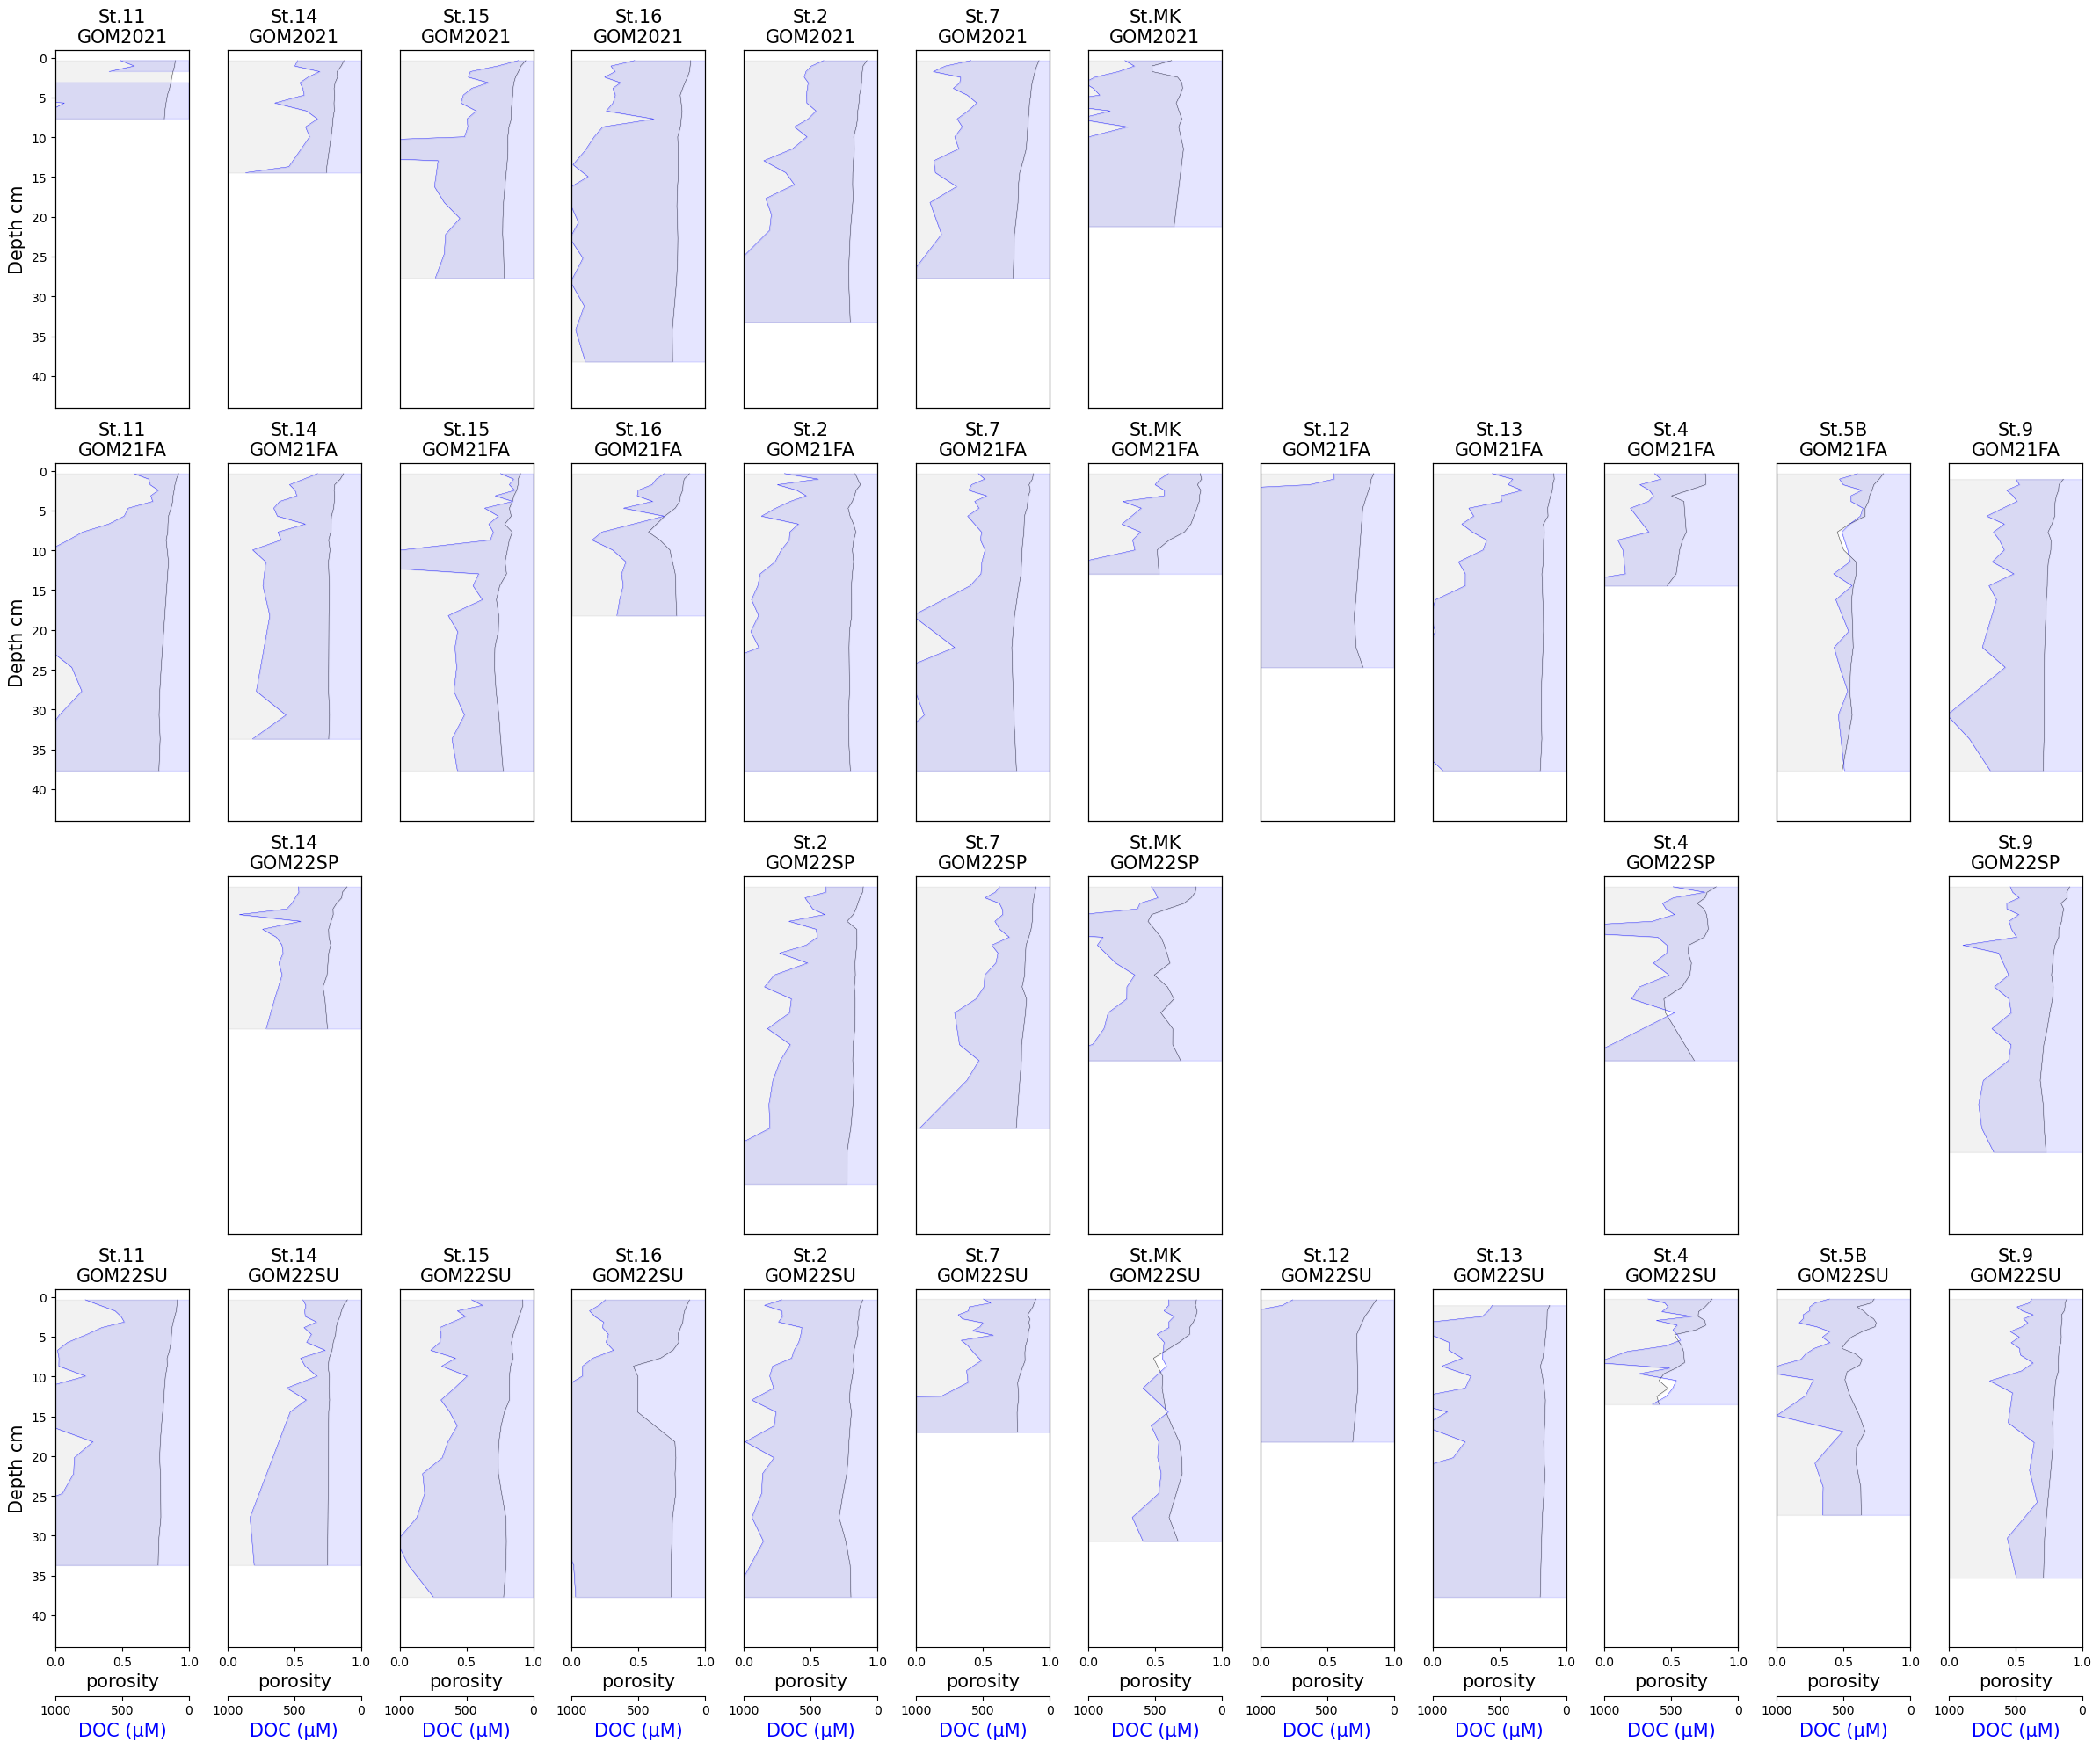

In [11]:
stations = interpolated_df['stn'].unique()
trips = interpolated_df['camp'].unique()

fig, axes = plt.subplots(len(trips), len(stations), figsize=(len(stations)*2, len(trips)*5))

for i, trip in enumerate(trips):
    for j, station in enumerate(stations):
        # Filter by trip and station
        #get data 
        data = interpolated_df[(interpolated_df['camp'] == trip) & (interpolated_df['stn'] == station)]
    
        #For Pore Waters 
        #get vars DOC 
        fe2 = data['DOC'] 
        #fe2 = np.asarray(fe2, dtype=float).ravel()
        por = data['por_interpolated'] 
        #por = np.asarray(por, dtype=float).ravel()
        depth = data['Depth'] #X var 
        #depth = np.asarray(depth, dtype=float).ravel()

        if not data.empty:
            ax = axes[i, j]
            
            ax.plot(por, depth, c = 'black', lw = .25)
            ax.fill_betweenx(depth, por, color='grey', alpha=0.1)
            ax.set_title(f'{station}\n{trip}', size=15)
            ax.set_ylim(44, -1)
            ax.set_xlim(0, 1)
            
            ax3 = ax.twiny()
            ax3.plot(fe2, depth, c = 'blue', lw = .25)
            ax3.fill_betweenx(depth, fe2, color='blue', alpha=0.1)
            ax3.set_ylim(44, -1)
            ax3.set_xlim(1000, 0)
            
        else: 
            axes[i, j].axis('off')  
        if j == 0:
            axes[i,j].set_ylabel('Depth cm', size=15, c='black')
            axes[i,j].yaxis.set_tick_params(labelsize=10)
        else: 
            ax.set_ylabel('')
            ax.yaxis.set_ticklabels([])
            ax.set_yticks([])
        
        if i == 3:
            ax.set_xlabel('porosity', size=15, c='black')
            ax.xaxis.set_tick_params(labelsize=10)
            
            ax3.set_xlabel('DOC (\u03BCM)', size = 15, c= 'blue')
            ax3.xaxis.set_ticks_position('bottom')
            ax3.xaxis.set_label_position('bottom')
            ax3.spines['bottom'].set_position(('outward', 40))
            
        else: 
            ax.set_xlabel('')
            ax.xaxis.set_ticklabels([])
            ax.set_xticks([])
            
            
            ax3.set_xlabel('')
            ax3.xaxis.set_ticklabels([])
            ax3.set_xticks([])
            
            
plt.tight_layout()
fig.set_facecolor('w')
#plt.savefig(f'../Dissertation_projects/Figures/Pore_water_profiles/profile_carbon.png')
plt.show()


In [12]:
df_cal = interpolated_df
df_cal['sed_density_Gpercm3'] = 2.6

#fe uM to M 
df_cal['doc_mol_per_m3'] =  df_cal['DOC'] / 1000000 * 1000

df_cal['doc_mol_per_m3_vol'] =  df_cal['doc_mol_per_m3'] * df_cal['por_interpolated']

df_cal['depth_m'] = df_cal['Depth'] / 100

df_cal

por_interpolated  Depth        DOC           code    stn     camp  \
0            0.897196   0.35   514.1250  St.11_GOM2021  St.11  GOM2021   
1            0.891846   1.05   409.1875  St.11_GOM2021  St.11  GOM2021   
2            0.879845   1.75   596.8750  St.11_GOM2021  St.11  GOM2021   
3            0.870578   2.45        NaN  St.11_GOM2021  St.11  GOM2021   
4            0.864441   3.15  1646.8750  St.11_GOM2021  St.11  GOM2021   
..                ...    ...        ...            ...    ...      ...   
688          0.699232  20.20   480.1875  St.MK_GOM22SU  St.MK  GOM22SU   
689          0.704056  22.20   453.7500  St.MK_GOM22SU  St.MK  GOM22SU   
690          0.659089  24.70   472.8125  St.MK_GOM22SU  St.MK  GOM22SU   
691          0.605461  27.70   670.1250  St.MK_GOM22SU  St.MK  GOM22SU   
692          0.673309  30.70   589.1875  St.MK_GOM22SU  St.MK  GOM22SU   

     sed_density_Gpercm3  doc_mol_per_m3  doc_mol_per_m3_vol  depth_m  
0                    2.6        0.514125            0.461271   0.0035  
1                    2.6        0.409187            0.364932   0.0105  
2                    2.6        0.596875            0.525157   0.0175  
3                    2.6             NaN                 NaN   0.0245  
4                    2.6        1.646875            1.423626   0.0315  
..                   ...             ...                 ...      ...  
688                  2.6        0.480187            0.335762   0.2020  
689                  2.6        0.453750            0.319465   0.2220  
690                  2.6        0.472812            0.311626   0.2470  
691                  2.6        0.670125            0.405735   0.2770  
692                  2.6        0.589187            0.396705   0.3070  

[693 rows x 10 columns]

In [13]:
codes_list

array(['St.11_GOM2021', 'St.14_GOM2021', 'St.15_GOM2021', 'St.16_GOM2021',
       'St.2_GOM2021', 'St.4_GOM2021', 'St.5B_GOM2021', 'St.7_GOM2021',
       'St.9_GOM2021', 'St.MK_GOM2021', 'St.11_GOM21FA', 'St.12_GOM21FA',
       'St.13_GOM21FA', 'St.14_GOM21FA', 'St.15_GOM21FA', 'St.16_GOM21FA',
       'St.2_GOM21FA', 'St.4_GOM21FA', 'St.5B_GOM21FA', 'St.7_GOM21FA',
       'St.9_GOM21FA', 'St.MK_GOM21FA', 'St.14_GOM22SP', 'St.2_GOM22SP',
       'St.4_GOM22SP', 'St.7_GOM22SP', 'St.9_GOM22SP', 'St.MK_GOM22SP',
       'St.11_GOM22SU', 'St.12_GOM22SU', 'St.13_GOM22SU', 'St.14_GOM22SU',
       'St.15_GOM22SU', 'St.16_GOM22SU', 'St.2_GOM22SU', 'St.4_GOM22SU',
       'St.5B_GOM22SU', 'St.7_GOM22SU', 'St.9_GOM22SU', 'St.MK_GOM22SU'],
      dtype=object)

In [14]:
Frames = []

for code in codes_list: 
    df_play = df_cal[df_cal['code'] == code] 

    # Create a row with NaN values
    new_row = pd.DataFrame([np.nan] * len(df_play.columns)).T

    # Set column names for the new row
    new_row.columns = df_play.columns
    new_row['depth_m'] = 0 
    new_row['doc_mol_per_m3_vol'] = 0 

    # Append the new row to the DataFrame
    df_play = pd.concat([pd.DataFrame(new_row), df_play], ignore_index=True)

    ds_fet = df_play.dropna(subset=['depth_m', 'doc_mol_per_m3_vol'])


    # Define the depth range you want to integrate over
    start_depth = 0
    stop_depth = .05

    # Interpolating concentration at depth 5 using linear interpolation
    fet_at_depth_5 = np.interp(stop_depth, ds_fet['depth_m'], ds_fet['doc_mol_per_m3_vol'])

    #add he depth 5 data  
    new_row.columns = ds_fet.columns
    new_row['depth_m'] = stop_depth
    new_row['doc_mol_per_m3_vol'] = fet_at_depth_5


    # Selecting data within the specified depth range
    selected_data_fet = ds_fet[(ds_fet['depth_m'] >= start_depth) & (ds_fet['depth_m'] <= stop_depth)]
    selected_data_fet = pd.concat([selected_data_fet, new_row])
    
    # Calculating the integral using the trapezoidal rule
    integral_fet = np.trapz(selected_data_fet['doc_mol_per_m3_vol'], selected_data_fet['depth_m']) / stop_depth

    dic = {'code':[code],
           'doc_mol_per_m3_0_to_5cm':[integral_fet]}
        
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    Frames.append(slopes)
    
stocks_pw_fe_5 = pd.concat(Frames, axis=0, ignore_index=False)

stocks_pw_fe_5

doc_mol_per_m3_0_to_5cm
code                                  
St.11_GOM2021                 0.923105
St.14_GOM2021                 0.340952
St.15_GOM2021                 0.328016
St.16_GOM2021                 0.555662
St.2_GOM2021                  0.436882
St.4_GOM2021                  0.000000
St.5B_GOM2021                 0.000000
St.7_GOM2021                  0.600673
St.9_GOM2021                  0.000000
St.MK_GOM2021                 0.531959
St.11_GOM21FA                 0.273043
St.12_GOM21FA                 1.413694
St.13_GOM21FA                 0.415886
St.14_GOM21FA                 0.400440
St.15_GOM21FA                 0.177777
St.16_GOM21FA                 0.350724
St.2_GOM21FA                  0.507289
St.4_GOM21FA                  0.423393
St.5B_GOM21FA                 0.302104
St.7_GOM21FA                  0.442762
St.9_GOM21FA                  0.382546
St.MK_GOM21FA                 0.415638
St.14_GOM22SP                 0.444494
St.2_GOM22SP                  0.391753
St.4_GOM22SP                  0.367531
St.7_GOM22SP                  0.334009
St.9_GOM22SP                  0.438893
St.MK_GOM22SP                 0.537495
St.11_GOM22SU                 0.538673
St.12_GOM22SU                 1.172272
St.13_GOM22SU                 0.613012
St.14_GOM22SU                 0.327437
St.15_GOM22SU                 0.482807
St.16_GOM22SU                 0.634287
St.2_GOM22SU                  0.576511
St.4_GOM22SU                  0.360399
St.5B_GOM22SU                 0.481853
St.7_GOM22SU                  0.462417
St.9_GOM22SU                  0.368780
St.MK_GOM22SU                 0.311114

In [15]:
Frames = []

for code in codes_list: 
    df_play = df_cal[df_cal['code'] == code] 

    # Create a row with NaN values
    new_row = pd.DataFrame([np.nan] * len(df_play.columns)).T

    # Set column names for the new row
    new_row.columns = df_play.columns
    new_row['depth_m'] = 0 
    new_row['doc_mol_per_m3_vol'] = 0 

    # Append the new row to the DataFrame
    df_play = pd.concat([pd.DataFrame(new_row), df_play], ignore_index=True)

    ds_fet = df_play.dropna(subset=['depth_m', 'doc_mol_per_m3_vol'])

    # Define the depth range you want to integrate over
    start_depth = 0
    stop_depth = .25

    # Interpolating concentration at depth 5 using linear interpolation
    fet_at_depth_5 = np.interp(stop_depth, ds_fet['depth_m'], ds_fet['doc_mol_per_m3_vol'])

    #add he depth 5 data  
    new_row.columns = ds_fet.columns
    new_row['depth_m'] = stop_depth
    new_row['doc_mol_per_m3_vol'] = fet_at_depth_5


    # Selecting data within the specified depth range
    selected_data_fet = ds_fet[(ds_fet['depth_m'] >= start_depth) & (ds_fet['depth_m'] <= stop_depth)]
    selected_data_fet = pd.concat([selected_data_fet, new_row])
    
    # Calculating the integral using the trapezoidal rule
    integral_fet = np.trapz(selected_data_fet['doc_mol_per_m3_vol'], selected_data_fet['depth_m']) / stop_depth

    dic = {'code':[code],
           'doc_mol_per_m3_0_to_25cm':[integral_fet]}
        
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    Frames.append(slopes)
    
stocks_pw_fe_25 = pd.concat(Frames, axis=0, ignore_index=False)

stocks_pw_fe_25

doc_mol_per_m3_0_to_25cm
code                                   
St.11_GOM2021                  0.886844
St.14_GOM2021                  0.474728
St.15_GOM2021                  0.572516
St.16_GOM2021                  0.678459
St.2_GOM2021                   0.553022
St.4_GOM2021                   0.000000
St.5B_GOM2021                  0.000000
St.7_GOM2021                   0.603919
St.9_GOM2021                   0.000000
St.MK_GOM2021                  1.032982
St.11_GOM21FA                  0.724837
St.12_GOM21FA                  1.459948
St.13_GOM21FA                  0.654609
St.14_GOM21FA                  0.502092
St.15_GOM21FA                  0.403088
St.16_GOM21FA                  0.454278
St.2_GOM21FA                   0.657814
St.4_GOM21FA                   0.543309
St.5B_GOM21FA                  0.282544
St.7_GOM21FA                   0.514145
St.9_GOM21FA                   0.462751
St.MK_GOM21FA                  0.613370
St.14_GOM22SP                  0.483565
St.2_GOM22SP                   0.530332
St.4_GOM22SP                   0.484848
St.7_GOM22SP                   0.414558
St.9_GOM22SP                   0.451970
St.MK_GOM22SP                  0.608355
St.11_GOM22SU                  0.727339
St.12_GOM22SU                  1.315404
St.13_GOM22SU                  0.749903
St.14_GOM22SU                  0.394458
St.15_GOM22SU                  0.517266
St.16_GOM22SU                  0.692940
St.2_GOM22SU                   0.623426
St.4_GOM22SU                   0.304366
St.5B_GOM22SU                  0.446191
St.7_GOM22SU                   2.775696
St.9_GOM22SU                   0.366778
St.MK_GOM22SU                  0.297845

In [16]:
stocks_pw_fe = pd.concat([stocks_pw_fe_25, stocks_pw_fe_5], axis=1)
stocks_pw_fe.to_csv('../Dissertation_projects/Data/Stats_data_sets/DOC_stocks.csv')
stocks_pw_fe

doc_mol_per_m3_0_to_25cm  doc_mol_per_m3_0_to_5cm
code                                                            
St.11_GOM2021                  0.886844                 0.923105
St.14_GOM2021                  0.474728                 0.340952
St.15_GOM2021                  0.572516                 0.328016
St.16_GOM2021                  0.678459                 0.555662
St.2_GOM2021                   0.553022                 0.436882
St.4_GOM2021                   0.000000                 0.000000
St.5B_GOM2021                  0.000000                 0.000000
St.7_GOM2021                   0.603919                 0.600673
St.9_GOM2021                   0.000000                 0.000000
St.MK_GOM2021                  1.032982                 0.531959
St.11_GOM21FA                  0.724837                 0.273043
St.12_GOM21FA                  1.459948                 1.413694
St.13_GOM21FA                  0.654609                 0.415886
St.14_GOM21FA                  0.502092                 0.400440
St.15_GOM21FA                  0.403088                 0.177777
St.16_GOM21FA                  0.454278                 0.350724
St.2_GOM21FA                   0.657814                 0.507289
St.4_GOM21FA                   0.543309                 0.423393
St.5B_GOM21FA                  0.282544                 0.302104
St.7_GOM21FA                   0.514145                 0.442762
St.9_GOM21FA                   0.462751                 0.382546
St.MK_GOM21FA                  0.613370                 0.415638
St.14_GOM22SP                  0.483565                 0.444494
St.2_GOM22SP                   0.530332                 0.391753
St.4_GOM22SP                   0.484848                 0.367531
St.7_GOM22SP                   0.414558                 0.334009
St.9_GOM22SP                   0.451970                 0.438893
St.MK_GOM22SP                  0.608355                 0.537495
St.11_GOM22SU                  0.727339                 0.538673
St.12_GOM22SU                  1.315404                 1.172272
St.13_GOM22SU                  0.749903                 0.613012
St.14_GOM22SU                  0.394458                 0.327437
St.15_GOM22SU                  0.517266                 0.482807
St.16_GOM22SU                  0.692940                 0.634287
St.2_GOM22SU                   0.623426                 0.576511
St.4_GOM22SU                   0.304366                 0.360399
St.5B_GOM22SU                  0.446191                 0.481853
St.7_GOM22SU                   2.775696                 0.462417
St.9_GOM22SU                   0.366778                 0.368780
St.MK_GOM22SU                  0.297845                 0.311114